In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [12]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw_centered
from detector import (LinearSlidingWindowTransformerDetector, 
                      SlidingWindowTransformerDetector, 
                      FineTunedSlidingWindowDetector)

from data import CachedArtifactDataset, TestArtifactDataset, CenteredArtifactDataset

In [3]:
torch.set_grad_enabled(False)

In [4]:
test_width = 512
test_file = Path(f"../data/test_slidingWindow_{test_width}.pkl")
# test_datasets = [
#     "australian_electricity_demand_dataset", # accuracy  ~0.95
#     "electricity_hourly_dataset", # accuracy ~0.976
#     "electricity_load_diagrams", # ~0.953
#     "HouseholdPowerConsumption1",
#     "HouseholdPowerConsumption2",
#     "london_smart_meters_dataset_without_missing_values",
#     "solar_10_minutes_dataset",
#     "wind_farms_minutely_dataset_without_missing_values",
# ]

In [5]:
def load_series(names: list[str], split: str):
    series = list()
    counts = list()
    for name in names:
        with open(f"../data/processed/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > test_width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, counts / counts.sum()

In [6]:
# # validation
# if not test_file.exists():
#     val_data, val_weights = load_series(test_datasets, "VAL")
#     val_gen = CenteredArtifactDataset(
#         val_data,
#         width=test_width,
#         padding=64,
#         artifact=Saw_centered(),
#         weight=val_weights,
#     )
#     val = CachedArtifactDataset.generate(val_gen,
#                                          n=2048,
#                                          to=test_file)
# else:
val = CachedArtifactDataset(file=test_file)

In [7]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [38]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

data_asset = ml_client.data.get("output_Train_GPU_slidingWindow_AvgPool", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_detector = SlidingWindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/SlidingWindowTransformerDetector_528.96K_06-03-2024_10:39:23-step=1000.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_slidingWindow", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
linear_transformer_detector = LinearSlidingWindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=30000-v1.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_fineTune_slidingWindow", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
finetuned_transformer_detector = FineTunedSlidingWindowDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=14000-v1.ckpt").cpu()

Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'https://m3mlopssadev.blob.core.windows.net/azureml-blobstore-206414f2-5a5c-4209-8dbe-6d0e233cd920/artifactory/' './checkpoints_transformer/' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'https://m3mlopssadev.blob.core.windows.net/azureml-blobstore-206414f2-5a5c-4209-8dbe-6d0e233cd920/artifactory/' './checkpoints_transformer/' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'h

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

metrics = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'mse'])
index = 0

preds_trans = list()
preds_lin_trans = list()
preds_ft_trans = list()

gt = list()

for sample in val:
    example = sample["data"]
    stride  = 64
    window  = test_width
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    prediction_trans = transformer_detector(example_data.unsqueeze(0))
    prediction_lin_trans = linear_transformer_detector(example_data.unsqueeze(0))
    prediction_ft_trans = finetuned_transformer_detector(example_data.unsqueeze(0))

    preds_trans = preds_trans + [prediction_trans.numpy()]
    preds_lin_trans = preds_lin_trans + [prediction_lin_trans.numpy()]
    preds_ft_trans = preds_ft_trans + [prediction_ft_trans.numpy()]
    gt = gt + [sample["label"]]


In [41]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_trans)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

precision_lin, recall_lin, thresholds = precision_recall_curve(gt, preds_lin_trans)
J = precision_lin + recall_lin
ix = np.argmax(J)
best_thresh_pr_lin = thresholds[ix]

precision_ft, recall_ft, thresholds = precision_recall_curve(gt, preds_ft_trans)
J = precision_ft + recall_ft
ix = np.argmax(J)
best_thresh_pr_ft = thresholds[ix]

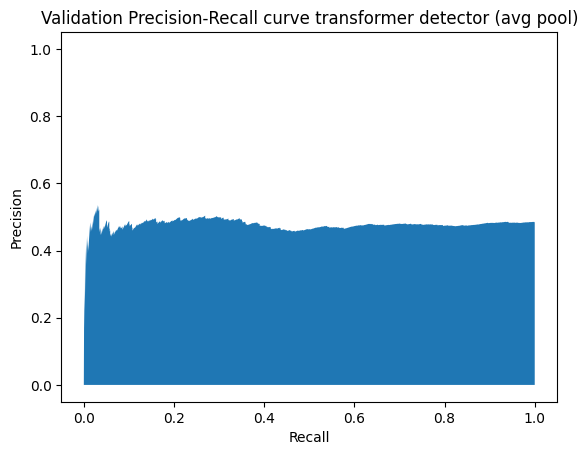

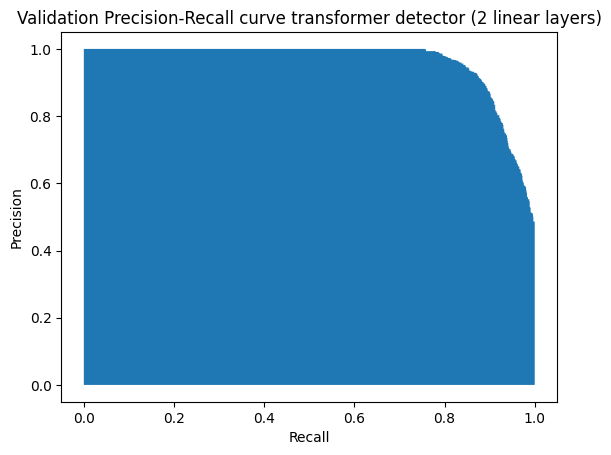

Text(0.5, 1.0, 'Validation Precision-Recall curve transformer detector (fine tuned)')

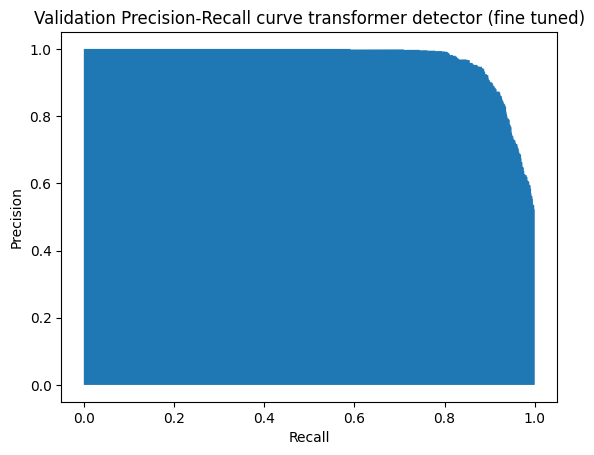

In [42]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve transformer detector (avg pool)")
plt.show()

plt.fill_between(recall_lin, precision_lin)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve transformer detector (2 linear layers)")
plt.show()

plt.fill_between(recall_ft, precision_ft)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve transformer detector (fine tuned)")

In [50]:
from sklearn.metrics import fbeta_score

beta=0.5

max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_trans = np.where(preds_trans > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_trans, average='macro', beta=beta)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta = threshold

max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_lin_trans = np.where(preds_lin_trans > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_lin_trans, average='macro', beta=beta)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_lin = threshold
        
max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_ft_trans = np.where(preds_ft_trans > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_ft_trans, average='macro', beta=beta)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_ft = threshold

In [51]:
best_threshold_fbeta_ft

0.4545454545454546

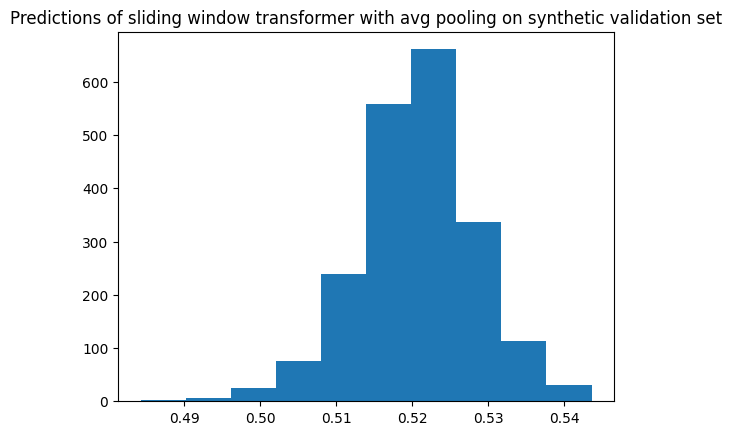

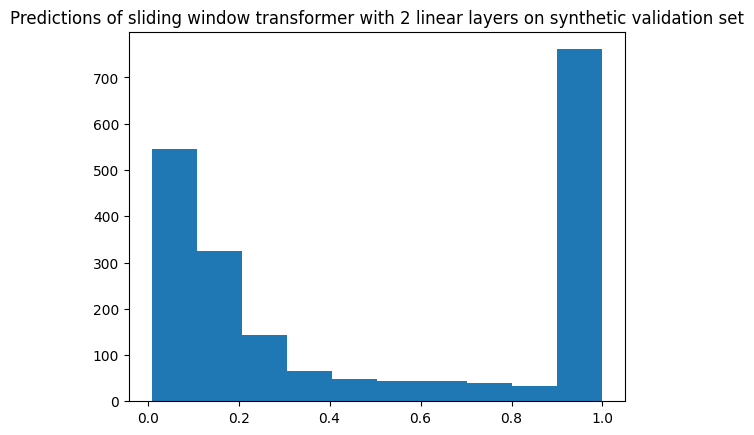

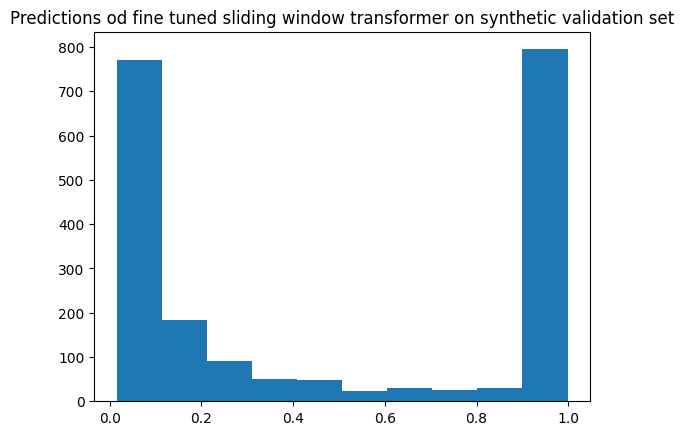

In [52]:
# Create the bar plot
plt.hist(preds_trans, bins=10)

# Customize the plot (optional)
plt.title("Predictions of sliding window transformer with avg pooling on synthetic validation set")

# Display the plot
plt.show()


# Create the bar plot
plt.hist(preds_lin_trans, bins=10)

# Customize the plot (optional)
plt.title("Predictions of sliding window transformer with 2 linear layers on synthetic validation set")

# Display the plot
plt.show()

# Create the bar plot
plt.hist(preds_ft_trans, bins=10)

# Customize the plot (optional)
plt.title("Predictions od fine tuned sliding window transformer on synthetic validation set")

# Display the plot
plt.show()

In [53]:
preds_binary = [1 if value >= best_threshold_fbeta else 0 for value in preds_trans]
preds_binary_lin = [1 if value >= best_threshold_fbeta_lin else 0 for value in preds_lin_trans]
preds_binary_ft = [1 if value >= best_threshold_fbeta_ft else 0 for value in preds_ft_trans]

tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(gt, preds_binary, labels=[0, 1]).ravel()
tn_lin, fp_lin, fn_lin, tp_lin = confusion_matrix(gt, preds_binary_lin, labels=[0, 1]).ravel()
tn_ft, fp_ft, fn_ft, tp_ft = confusion_matrix(gt, preds_binary_ft, labels=[0, 1]).ravel()

metrics = pd.DataFrame([
{
    'detector': 'avgPool_slidingWindow_transformer',
    'threshold': best_threshold_fbeta,
    'accuracy': accuracy_score(gt, preds_binary),
    'precision': precision_score(gt, preds_binary),
    'recall': recall_score(gt, preds_binary),
    'mse': mean_squared_error(gt, preds_binary),
    'tn': tn_trans,
    'fp': fp_trans, 
    'fn': fn_trans, 
    'tp': tp_trans
},
{
    'detector': 'linear_slidingWindow_transformer',
    'threshold': best_threshold_fbeta_lin,
    'accuracy': accuracy_score(gt, preds_binary_lin),
    'precision': precision_score(gt, preds_binary_lin),
    'recall': recall_score(gt, preds_binary_lin),
    'mse': mean_squared_error(gt, preds_binary_lin),
    'tn': tn_lin,
    'fp': fp_lin, 
    'fn': fn_lin, 
    'tp': tp_lin
},
{
    'detector': 'fineTuned_slidingWindow_transformer',
    'threshold': best_threshold_fbeta_ft,
    'accuracy': accuracy_score(gt, preds_binary_ft),
    'precision': precision_score(gt, preds_binary_ft),
    'recall': recall_score(gt, preds_binary_ft),
    'mse': mean_squared_error(gt, preds_binary_ft),
    'tn': tn_ft,
    'fp': fp_ft, 
    'fn': fn_ft, 
    'tp': tp_ft
}])

In [49]:
metrics

,detector,threshold,accuracy,precision,recall,mse,tn,fp,fn,tp
0,avgPool_slidingWindow_transformer,0.525253,0.515625,0.500000,0.269153,0.484375,789,267,725,267
1,linear_slidingWindow_transformer,0.616162,0.904297,0.956422,0.840726,0.095703,1018,38,158,834
2,fineTuned_slidingWindow_transformer,0.616162,0.915039,0.966895,0.853831,0.084961,1027,29,145,847
